https://medium.com/beyondminds/an-introduction-to-super-resolution-using-deep-learning-f60aff9a499d
dataset can be found here: https://www.kaggle.com/olgabelitskaya/flower-color-images
tensorflow code can be found here: https://www.tensorflow.org/hub/tutorials/image_enhancing
another super resolution link that might be a little above my level: https://towardsdatascience.com/deep-learning-based-super-resolution-without-using-a-gan-11c9bb5b6cd5
I'm going to be implementing some ideas in this research paper: https://arxiv.org/pdf/1902.06068.pdf (page 5+)

--reword-
deep learning can be used to estimate the High Resolution (HR) image given a Low Resolution (LR) image. By using the HR image as a target (or ground-truth) and the LR image as an input, we can treat this like a supervised learning problem.

In [1]:
import tensorflow as tf
import numpy as np
import os
import time
from PIL import Image
import tensorflow_hub as hub

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import itertools
from tensorflow import keras
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.version.VERSION
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Importing the data

In [4]:
base_dir = os.path.join(os.getcwd(), os.pardir, "flowers","flowers")

In [5]:
flower_pictures = os.listdir(base_dir)
print(flower_pictures[:10])

['00_001.png', '00_002.png', '00_003.png', '00_004.png', '00_005.png', '00_006.png', '00_007.png', '00_008.png', '00_009.png', '00_010.png']


In [6]:
print("Dataset contains " + str(len(flower_pictures)) + " pictures")

Dataset contains 603 pictures


# Image Super Resolution using ESRGAN

In [7]:
# Loads image from path and preprocesses to make it model ready
def preprocess_image(image_path):
    # reads file from image path and decodes image as a tf EagerTensor
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    # the model I'm using only supports images with 3 color channels
    # my dataset is composed of png files which have 4 color chanels, so I'm going to remove the alpha channel to have 3 channels
    hr_image = hr_image[...,:-1]
    # cast to float32 instead of int
    hr_image = tf.cast(hr_image, tf.float32)
    # add a dimension to the beginning
    hr_image = tf.expand_dims(hr_image, 0)
    return hr_image

In [8]:
# ensures the image is in the correct Image.Image format, then saves the image as a jpg
def save_image(image, filename):
    # checking if image is type Image.Image (values between 0-255 and of type uint8)
    if not isinstance(image, Image.Image):
    # modifying the image to have values between 0-255 and to be of type unint8
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    # save the image as a jpg using the name specified
    image.save("%s.jpg" % filename)
    print("Saved as %s.jpg" % filename)

In [9]:
# plots the image
def plot_image(image, title=""):
    # converting to int32 since images with type int can have values between 0-255
    # whereas images with type float can have values between 0-1
    image = tf.cast(image, tf.int32).numpy()
    # clipping the image to ensure it is within the range of 0-255
    image = tf.clip_by_value(image, 0, 255)
    # altering the figure size to be slightly larger, in order to better see the blurriness/sharpness of the image
    plt.figure(figsize=(5, 5))
    # showing the image
    plt.imshow(tf.squeeze(image))
    # removing the axes from view
    plt.axis("off")
    # titling the plot
    plt.title(title)

In [10]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

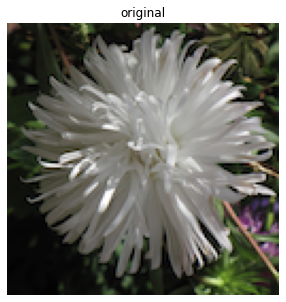

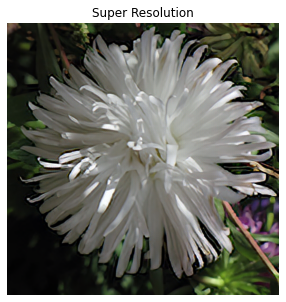

In [282]:
image_1 = os.path.join(base_dir, flower_pictures[555])
hr_image = preprocess_image(image_1)
plot_image(hr_image, "original")

fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
plot_image(tf.squeeze(fake_image), title= "Super Resolution")

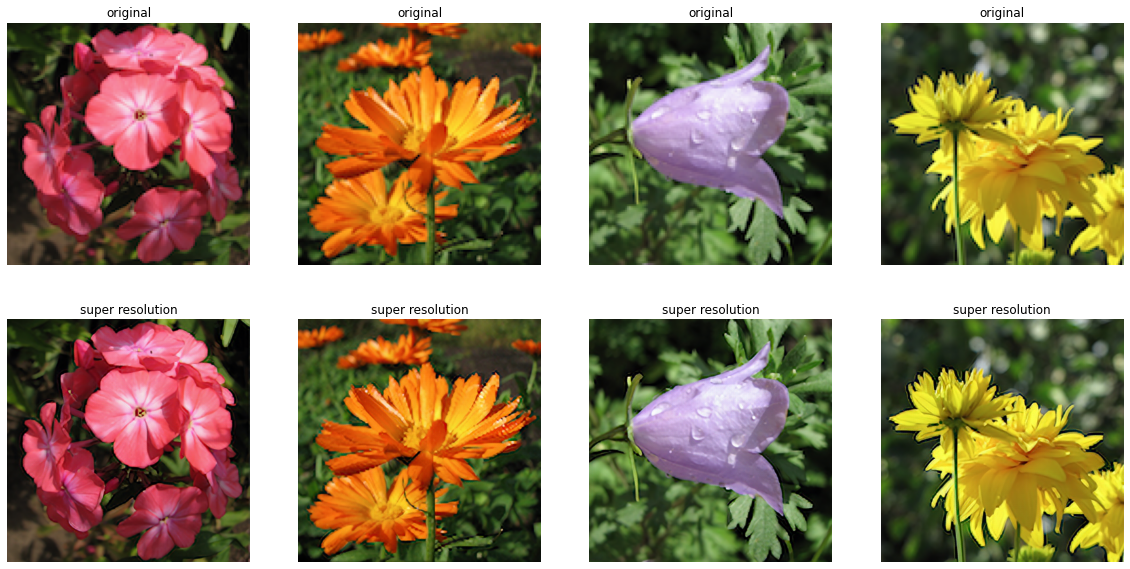

In [107]:
n = 4 # how many pictures to display
plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    image_path = os.path.join(base_dir, flower_pictures[i*100])
    image = preprocess_image(image_path)
    image2 = tf.cast(image, tf.int32).numpy()
    image2 = tf.clip_by_value(image2, 0, 255)
    plt.imshow(tf.squeeze(image2))
    plt.axis("off")
    plt.title("original")
    
    ax = plt.subplot(2, n, i + 1 + n )
    hd_image = model(image)
    hd_image = tf.squeeze(hd_image)
    hd_image = tf.cast(hd_image, tf.int32).numpy()
    hd_image = tf.clip_by_value(hd_image, 0, 255)
    plt.imshow(tf.squeeze(hd_image))
    plt.axis("off")
    plt.title("super resolution")

In [11]:
image_path = os.path.join(base_dir, flower_pictures[256])
image = preprocess_image(image_path)

In [12]:
def downscale_image(image):
    image_size = []
    image = tf.squeeze(image)
    image_size = [image.shape[1], image.shape[0]]
    # ensuring that the image intensities are within the bounds 0-255 and that each value is an int
    image = tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8)
    # resizing the image to 25% of the size using cubic spline interpolation (Image.BICUBIC)
    lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4], Image.BICUBIC))
    # expanding dims and casting as float32 to put into the correct format to feed into pretrained model
    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

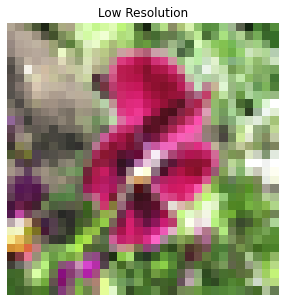

In [194]:
# downscaling and plotting low resolution image
low_res_image = downscale_image(image)
plot_image(low_res_image, title = "Low Resolution")

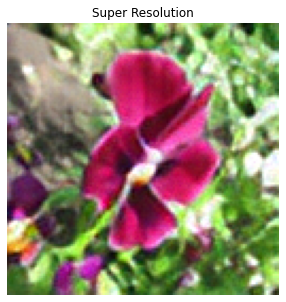

In [200]:
# improving the resolution of the image
super_res_image = model(low_res_image)
plot_image(super_res_image, "Super Resolution")

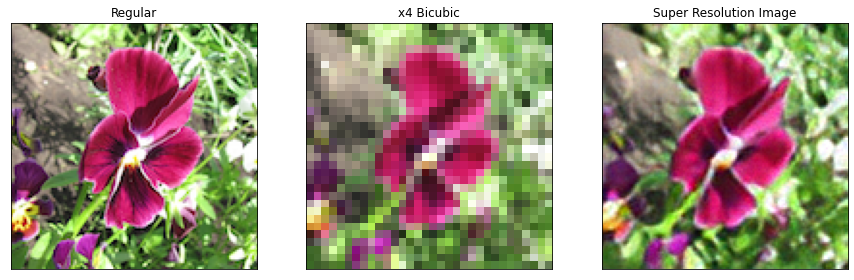

In [223]:
plt.figure(figsize = (15, 15))
ax = plt.subplot(2, 3, 1)
image = tf.cast(image, tf.int32).numpy()
image = tf.clip_by_value(image, 0, 255)
plt.imshow(tf.squeeze(image))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("Regular")

ax = plt.subplot(2, 3, 2)
low_res_image = tf.cast(low_res_image, tf.int32).numpy()
low_res_image = tf.clip_by_value(low_res_image, 0, 255)
plt.imshow(tf.squeeze(low_res_image))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("x4 Bicubic")

ax = plt.subplot(2, 3, 3)
super_res_image = tf.cast(super_res_image, tf.int32).numpy()
super_res_image = tf.clip_by_value(super_res_image, 0, 255)
plt.imshow(tf.squeeze(super_res_image))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("Super Resolution Image")
plt.show()

# Training my Own Super Resolution Neural Network
# The first step will be to take all of my high resolution images of food and convert them to low resolution using x4 Bicubic

In [7]:
def save_image(image, filename):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save("%s.jpg" % filename)

In [34]:
base_dir = os.path.join(os.getcwd(), os.pardir, "train_food_images_high_res" )
resized_dir = os.path.join(os.getcwd(), os.pardir, "resized_food_high_res_images")
converted_dir = os.path.join(os.getcwd(), os.pardir, "train_food_images_low_res" )

val_resized_dir = os.path.join(os.getcwd(), os.pardir, "val_resized_food_high_res_images")
val_converted_dir = os.path.join(os.getcwd(), os.pardir, "val_train_food_images_low_res" )

In [9]:
food_pictures = os.listdir(base_dir)
print(food_pictures[:10])

['1000016.jpg', '100009.jpg', '1000104.jpg', '1000205.jpg', '1000288.jpg', '1000314.jpg', '1000325.jpg', '1000351.jpg', '100038.jpg', '1000388.jpg']


In [10]:
print("Dataset contains " + str(len(food_pictures)) + " pictures")

Dataset contains 100994 pictures


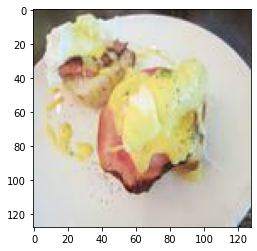

In [17]:
# checking the shape of the image
image_path = os.path.join(base_dir, "1000104.jpg")
image = tf.image.decode_image(tf.io.read_file(image_path))
#image.shape
plt.imshow(image)

In [329]:
image_path = os.path.join(base_dir, "1000104.jpg")
image = tf.image.decode_image(tf.io.read_file(image_path))
#image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
#image = image.resize((128, 128), Image.ANTIALIAS)
#image.save(image_path)
# convert the image to an array
#image = np.array(image)
#image = Image.fromarray(tf.cast(image, tf.uint8).numpy())

In [349]:
if not((image.shape[0] >= 100) & (image.shape[1] >= 100) & (image.shape[2] == 3)):
    print("yes")

In [346]:
image.shape

TensorShape([128, 128, 3])

In [350]:
food_pictures[20]

'1000678.jpg'

In [354]:
food_pictures[20]

'1000711.jpg'

-- reword --
One easy method of obtaining LR data is to degrade HR data. This is often done by blurring or adding noise. Images of lower spatial resolution can also be scaled by a classic upsampling method such as Bilinear or Bicubic interpolation.

In [356]:
# the images are not all the same size, and they are not in the right shape. So I need to do some preprocessing of the images
# iterate through every image: read the image, clip the image values, resize the image to 128x128, then save the new image
# I'm actually saving the image so that I have a copy of all of the original 'high-resolution' images to feed into the model
for i in range(len(food_pictures)):
    # get the path of the image
    image_path = os.path.join(base_dir, food_pictures[i])
    # decode the image as EagerTensor
    image = tf.image.decode_image(tf.io.read_file(image_path))
    # checking to make sure the image is at least of size 128x128x3, if it isn't then move on to the next image
    if not((image.shape[0] >= 128) & (image.shape[1] >= 128) & (image.shape[2] == 3)):
        #os.remove(image_path)
        continue
    # clip the values in the image to ensure they are between 0-255
    image = tf.clip_by_value(image, 0 , 255)
    # convert from EagerTensor to PIL image, cast all values as uint8
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    # resize the image so all images are the same size
    image = image.resize((128, 128), Image.ANTIALIAS)
    # save the image in the same place it was before
    image.save(os.path.join(resized_dir, food_pictures[i]))

In [360]:
# new food_pictures list composed of only the resized images
food_pictures = os.listdir(resized_dir)

In [358]:
# checking to ensure that all pictures are the same size (1 x 128 x 128 x 3)
for i in range(len(food_pictures)):
    image = os.path.join(resized_dir, food_pictures[i])
    hr_image = preprocess_food_image(image)
    if not(hr_image.shape == (1, 128, 128, 3)):
        print("picture " + str(food_pictures[i]) + " has a different size")

In [359]:
print("Dataset contains " + str(len(food_pictures)) + " pictures")

Dataset contains 100990 pictures


In [372]:
# get the path of the image
image_path = os.path.join(base_dir, food_pictures[0])
# decode the image as EagerTensor
image = tf.image.decode_image(tf.io.read_file(image_path))

In [383]:
# convert all the images to low resolution using Image.BICUBIC and save them to the coverted_dir
for i in range(len(food_pictures)):
    # get the path of the image
    image_path = os.path.join(resized_dir, food_pictures[i])
    # decode the image as EagerTensor
    image = tf.image.decode_image(tf.io.read_file(image_path))
    image_size = []
    image = tf.squeeze(image)
    image_size = [image.shape[1], image.shape[0]]
    # ensuring that the image intensities are within the bounds 0-255 and that each value is an int
    image = tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8)
    # resizing the image to 25% of the size using cubic spline interpolation (Image.BICUBIC)
    lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4], Image.BICUBIC))
    # expanding dims and casting as float32 to put into the correct format to feed into pretrained model
    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    lr_image = tf.squeeze(lr_image)
    lr_image = Image.fromarray(tf.cast(lr_image, tf.uint8).numpy())
    lr_image.save(os.path.join(converted_dir, food_pictures[i]))

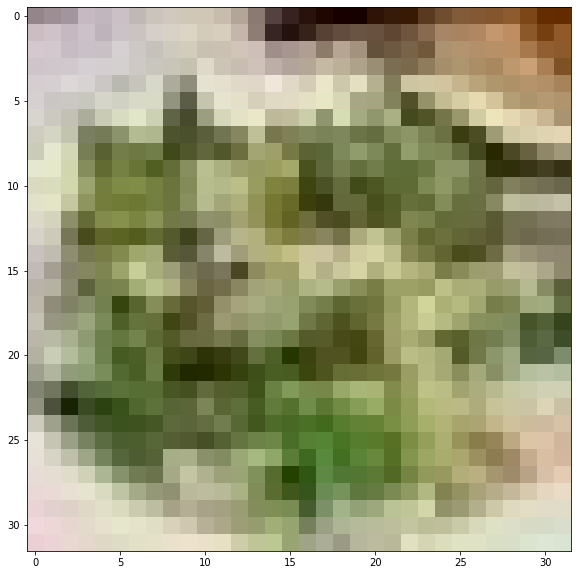

In [381]:
# get the path of the image
image_path = os.path.join(converted_dir, food_pictures[0])
# decode the image as EagerTensor
image = tf.image.decode_image(tf.io.read_file(image_path))
plt.imshow(image)

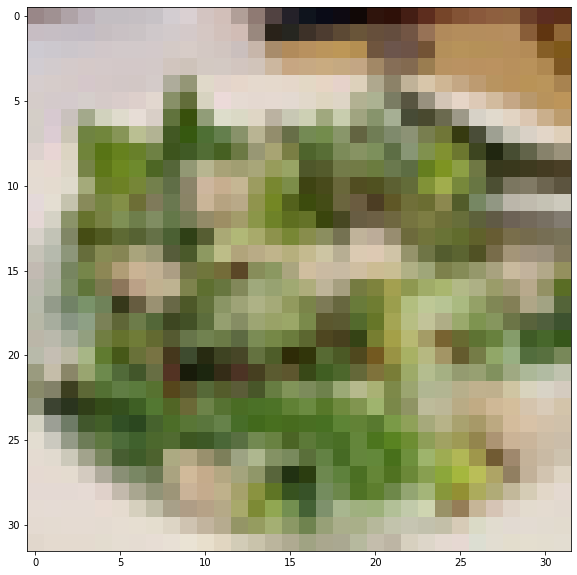

In [375]:
#lr_image = tf.clip_by_value(lr_image, 0, 255)
plt.imshow(tf.squeeze(tf.cast(lr_image, tf.uint8)))
#lr_image

In [ ]:
# now I'm going to convert all of those 128x128 images to their downscaled version
for i in range(len(food_pictures)):
    # get the path of the image
    image_path = os.path.join(base_dir, food_pictures[i])
    # decode the image as EagerTensor
    image = tf.image.decode_image(tf.io.read_file(image_path))
    
    image_size = []
    image = tf.squeeze(image)
    image_size = [image.shape[1], image.shape[0]]
    # ensuring that the image intensities are within the bounds 0-255 and that each value is an int
    image = tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8)
    # resizing the image to 25% of the size using cubic spline interpolation (Image.BICUBIC)
    lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4], Image.BICUBIC))
    # expanding dims and casting as float32 to put into the correct format to feed into pretrained model
    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

In [291]:
image.shape

(128, 128, 3)

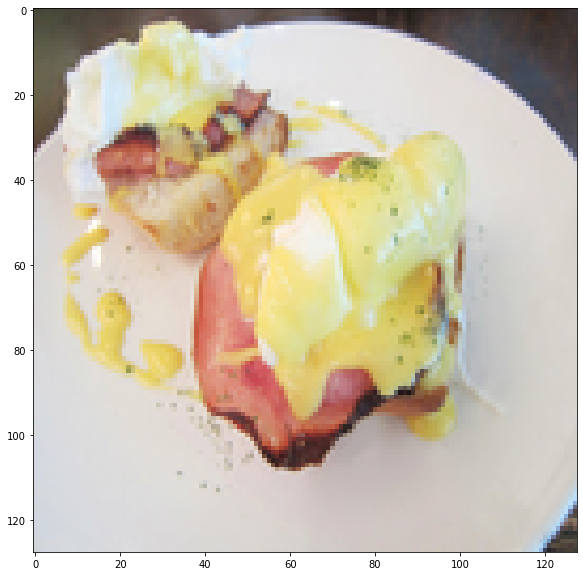

In [295]:
plt.imshow(image)

In [18]:
# Loads image from path and preprocesses to make it model ready
def preprocess_food_image(image_path):
    # reads file from image path and decodes image as a tf EagerTensor
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    # since the food images are of type jpg, they already have 3 color channels, so I don't need to remove a channel
    #hr_image = hr_image[...,:-1]
    # cast to float32 instead of int
    hr_image = tf.cast(hr_image, tf.float32)
    # add a dimension to the beginning
    hr_image = tf.expand_dims(hr_image, 0)
    return hr_image

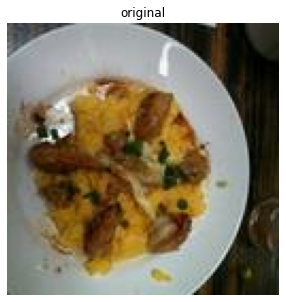

In [19]:
# after taking a look at the data, I can see that all of the images are 512 x 512 pixels
image_1 = os.path.join(base_dir, food_pictures[550])
hr_image = preprocess_food_image(image_1)
plot_image(hr_image, "original")

In [20]:
test_image = os.path.join(base_dir, "1000104.jpg")
hr_image = preprocess_food_image(test_image)
hr_image.shape

TensorShape([1, 128, 128, 3])

In [21]:
hr_image = tf.squeeze(hr_image)

# Methods of obtaining super resolution with NN architectures
Pre-Upsampling: low resolution images are first interpolated to obtain a “coarse” high resolution image. Now, CNNs are used to learn an end-to-end mapping from the interpolated low resolution images to the high resolution images.
Post-Upsampling:  the low resolution images are passed to the CNNs first. Upsampling is then performed in the last layer using a learnable layer.
Progressive Upsampling: the models use a cascade of CNNs to progressively reconstruct high resolution images at smaller scaling factors at each step.
Iterative Up and Down Sampling: the hourglass (or U-Net) structure. Some variants such as the Stacked Hourglass network use several hourglass structures in series, effectively alternating between the process of upsampling and downsampling.

In [59]:
input_img = tf.keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
model = keras.Model(input_img, x)
model.compile(optimizer='adam', loss = 'binary_crossentropy')

In [60]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
up_sampling2d_18 (UpSampling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
up_sampling2d_19 (UpSampling (None, 128, 128, 16)      0   

In [33]:
converted_dir

'C:\\Users\\lhm\\GitHub\\super_resolution\\super_resolution\\..\\train_food_images_low_res'

ValueError: `labels` argument should be a list/tuple of integer labels, of the same size as the number of image files in the target directory. If you wish to infer the labels from the subdirectory names in the target directory, pass `labels="inferred"`. If you wish to get a dataset that only contains images (no labels), pass `label_mode=None`.


In [48]:
labels_dataset = tf.keras.preprocessing.image_dataset_from_directory(resized_dir, label_mode=None, image_size=(128, 128), shuffle=False)

Found 100920 files belonging to 1 classes.


In [49]:
val_labels_dataset =tf.keras.preprocessing.image_dataset_from_directory(val_resized_dir, label_mode=None, image_size=(128, 128), shuffle=False)

Found 70 files belonging to 1 classes.


In [50]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(converted_dir,label_mode = None, image_size=(32, 32), shuffle=False)

Found 100920 files belonging to 1 classes.


In [51]:
val_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(val_converted_dir,label_mode = None, image_size=(32, 32), shuffle=False)

Found 70 files belonging to 1 classes.


In [52]:
zipped_ds = tf.data.Dataset.zip((train_dataset,labels_dataset))#.batch(32)

In [53]:
zipped_val_ds = tf.data.Dataset.zip((val_train_dataset,val_labels_dataset))

In [54]:
tf.config.run_functions_eagerly(True)

In [61]:
model.fit(zipped_ds,
         epochs=3,
         batch_size=32,
         validation_data = zipped_val_ds)

Epoch 1/3
3154/3154 [==============================] - 76s 24ms/step - loss: -14008993957195604.0000 - val_loss: -334366605607698432.0000
Epoch 2/3
3154/3154 [==============================] - 78s 25ms/step - loss: -1119557292937528064.0000 - val_loss: -5094010433451327488.0000
Epoch 3/3
3154/3154 [==============================] - 75s 24ms/step - loss: -9527061487074084864.0000 - val_loss: -23936684796032319488.0000


In [62]:
decoded_imgs = model.predict(zipped_val_ds)

In [63]:
decoded_imgs.shape

(70, 128, 128, 3)

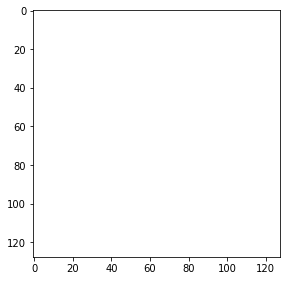

In [70]:
plt.figure(figsize=(10,10))
ax = plt.subplot(2, 2, 1)
plt.imshow(decoded_imgs[2].reshape(128,128,3))
plt.gray()

In [66]:
decoded_imgs[50]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)